In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )
import sidetable
import statsmodels.api as sm
import pylab as py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('tiktok_top_1000_2".csv', index_col=0)
df.head()

rank            account  subscribers_count  views_avg.  likes_avg.  \
0     1       billieeilish         41600000.0  95000000.0  18100000.0   
1     2           badbunny         13400000.0  33300000.0   7300000.0   
2     3  chipmunksoftiktok         11400000.0  25000000.0   3000000.0   
3     4      charlidamelio        135400000.0  18700000.0   2600000.0   
4     5         yessicadcs           263700.0  16700000.0   1400000.0   

   comments_avg.  shares_avg.  
0       151000.0      54800.0  
1       101900.0     106800.0  
2        21800.0      64200.0  
3        54700.0      35200.0  
4        16200.0     138400.0


Toma únicamente las variables de tipo numérico del dataset.
- Realiza un EDA explicando algunas de las cosas interesantes del conjunto de datos.
- Obtene la matriz de correlacion de las variables y estudia los resultados explicando las diferentes correlaciones con las variables.
- Limpia los datos de trabajo en caso de que sea necesario.

In [31]:
df.describe().T

count         mean           std       min         25%  \
rank               1000.0      500.500  2.888194e+02       1.0      250.75   
subscribers_count  1000.0  7049170.100  1.087267e+07    4300.0  1400000.00   
views_avg.         1000.0  3700866.300  4.697164e+06  585300.0  1800000.00   
likes_avg.         1000.0   453740.700  6.964760e+05   31000.0   230450.00   
comments_avg.      1000.0     4559.051  7.766146e+03       0.0     1600.00   
shares_avg.        1000.0    10681.079  1.677724e+05     212.0     1200.00   

                         50%         75%          max  
rank                   500.5      750.25       1000.0  
subscribers_count  3700000.0  8625000.00  135400000.0  
views_avg.         2600000.0  4000000.00   95000000.0  
likes_avg.          320200.0   478375.00   18100000.0  
comments_avg.         2800.0     4900.00     151000.0  
shares_avg.           2400.0     5400.00    5300000.0

In [32]:
df.stb.missing()

missing  total  percent
rank                     0   1000      0.0
account                  0   1000      0.0
subscribers_count        0   1000      0.0
views_avg.               0   1000      0.0
likes_avg.               0   1000      0.0
comments_avg.            0   1000      0.0
shares_avg.              0   1000      0.0

In [33]:
df.dtypes

rank                   int64
account               object
subscribers_count    float64
views_avg.           float64
likes_avg.           float64
comments_avg.        float64
shares_avg.          float64
dtype: object

In [3]:
df_numericas = df.select_dtypes(include=np.number)

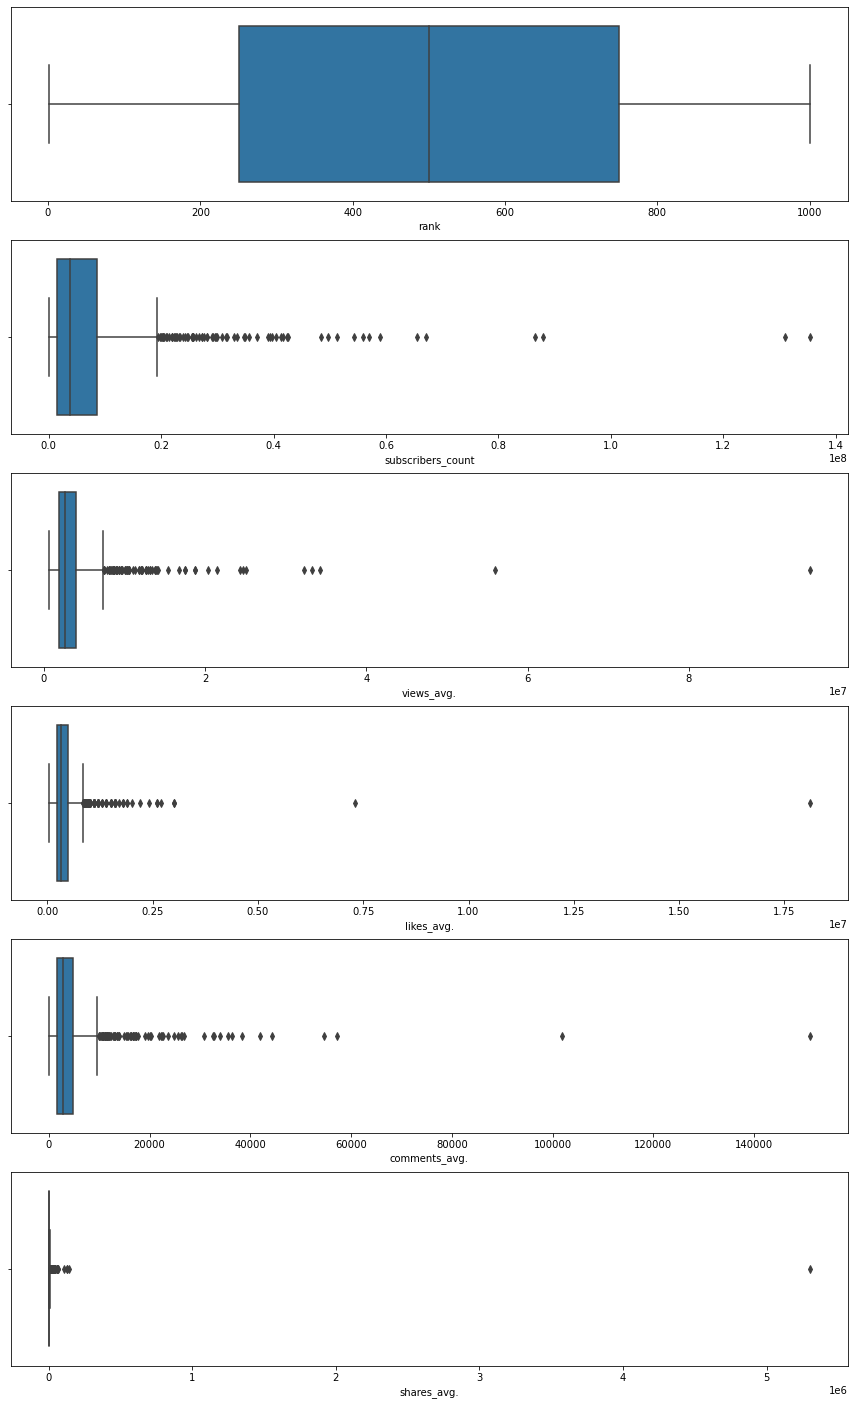

In [35]:
fig, axes = plt.subplots(6, 1, figsize=(15,25))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x = df_numericas.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

    Vemos que nuestras columnas numéricas tienen outliers, pero como la naturaleza de nuestros datos son visualizaciones, 'likes', suscriptores... tiene sentido que mantengamos estos outliers porque influyen en nuestras variables dependientes.

In [36]:
#sns.pairplot(df_numericas)

In [37]:
df_numericas.corr()

rank  subscribers_count  views_avg.  likes_avg.  \
rank               1.000000          -0.170179   -0.426099   -0.389007   
subscribers_count -0.170179           1.000000    0.245177    0.245597   
views_avg.        -0.426099           0.245177    1.000000    0.788605   
likes_avg.        -0.389007           0.245597    0.788605    1.000000   
comments_avg.     -0.379762           0.207978    0.613921    0.807356   
shares_avg.       -0.072801          -0.018577   -0.000647    0.005877   

                   comments_avg.  shares_avg.  
rank                   -0.379762    -0.072801  
subscribers_count       0.207978    -0.018577  
views_avg.              0.613921    -0.000647  
likes_avg.              0.807356     0.005877  
comments_avg.           1.000000     0.024031  
shares_avg.             0.024031     1.000000

    Vemos que en el DF todas las variables tienen alguna relación, porque ninguna es = 0. Pero, sin embargo, la mayoría tienen poca relación, exceptuando algunas como 'comments_avg' con 'likes_avg'(que tienen una correlación fuerte positiva porque es más de 0.8) o 'likes_avg' con 'views_avg'(tienen correlación positiva moderada porque es más de 0.6).

<AxesSubplot:>

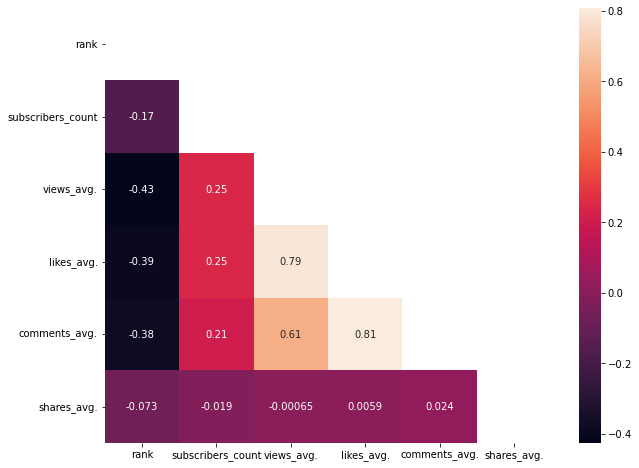

In [38]:
fig, ax = plt.subplots(figsize = (10,8))
corr = df_numericas.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

    Con este mapa de calor reforzamos lo explicado anteriormente. Vemos que los colores más claros que son las relaciones más fuertes, son escasos.

- Realiza el ajuste lineal múltiple mostrando las métricas.


In [39]:
df_numericas.head()

rank  subscribers_count  views_avg.  likes_avg.  comments_avg.  shares_avg.
0     1         41600000.0  95000000.0  18100000.0       151000.0      54800.0
1     2         13400000.0  33300000.0   7300000.0       101900.0     106800.0
2     3         11400000.0  25000000.0   3000000.0        21800.0      64200.0
3     4        135400000.0  18700000.0   2600000.0        54700.0      35200.0
4     5           263700.0  16700000.0   1400000.0        16200.0     138400.0

In [40]:
# x =df_numericas[['comments_avg.','views_avg.']]
# y = df_numericas['likes_avg.']
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# LR = LinearRegression() # nos aseguramos de que se normalizan los datos
# # Ajustamos el modelo
# LR.fit(x_train,y_train)
# y_prediction_train =  LR.predict(x_train)
# Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

# y_prediction =  LR.predict(x_test)
# Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# # Para el conjunto de entrenamiento las méticas han sido
# print('Para el conjunto train:---------------')
# print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
# print('El valor de r2 score adjusted es ',Adj_r2_train)
# print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
# print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# # Para el conjunto de test las métricas han sido
# print('Para el conjunto test:---------------')
# print('El valor de r2 score es ',r2_score(y_test,y_prediction))
# print('El valor de r2 score adjusted es ',Adj_r2_test)
# print('El MAE es',mean_absolute_error(y_test,y_prediction))
# print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.842697795407828
El valor de r2 score adjusted es  0.8423030596372076
El MAE es 167716.74806999974
EL RMSE es  302418.16859158146
Para el conjunto test:---------------
El valor de r2 score es  -0.7626265079012442
El valor de r2 score adjusted es  -0.7805211932606475
El MAE es 188289.52116344628
EL RMSE es  408557.62348358147


    De lo anterior podemos ver que el r² nos da un valor aceptable y cerca de uno lo cual nos indica que podriamos tener un buen ajuste lineal en el cojunto de entrenamiento, pero no pasa lo mismo con el del cojunto test. Así mismo, el r² ajustado no difiere mucho del valor de r², parece ser que no se ve demasiado penalizado por el número de regresores y esto pasa tanto en el conjunto entrenamiento como en el de test.

In [4]:
x =df_numericas.drop(columns = ['rank'])
y = df_numericas['rank']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression() # nos aseguramos de que se normalizan los datos
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.21268863920178238
El valor de r2 score adjusted es  0.20773075909600025
El MAE es 216.18019580970162
EL RMSE es  256.72463317840493
Para el conjunto test:---------------
El valor de r2 score es  0.1764301136476626
El valor de r2 score adjusted es  0.155204085648891
El MAE es 222.80566409441846
EL RMSE es  259.44394585687616


In [6]:
x =df_numericas.drop(columns = ['views_avg.'])
y = df_numericas['views_avg.']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression() # nos aseguramos de que se normalizan los datos
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.7571498754013237
El valor de r2 score adjusted es  0.7556205925008284
El MAE es 1182593.8495631358
EL RMSE es  2301640.0233589527
Para el conjunto test:---------------
El valor de r2 score es  0.20865838873458753
El valor de r2 score adjusted es  0.18826298638238614
El MAE es 1448064.0435984773
EL RMSE es  4260571.39804348


Toma ahora el dataset incluyendo las variables categóricas.
- Realiza el EDA de las variables categóricas que se va a incluir en el modelo.
- Utiliza algun tipo de codificación para las variables numéricas.
- Realiza la misma limpieza de datos, en caso necesario, aplicada en el dataset del apartado para dejar las variables numéricas limpias.
- Obten el ajuste lineal múltiple incluyendo las variables categóricas


In [51]:
df.dtypes

rank                   int64
account               object
subscribers_count    float64
views_avg.           float64
likes_avg.           float64
comments_avg.        float64
shares_avg.          float64
dtype: object

In [52]:
df.account.unique()

array(['billieeilish', 'badbunny', 'chipmunksoftiktok', 'charlidamelio',
       'yessicadcs', 'therock', 'the_pruld', 'lukedonkin', 'mastertingus',
       'txt.bighitent', 'besttoks', 'machinegunkelly', 'jenniferkershner',
       'noahschnapp', 'bdylanhollis', 'fisherbenny', 'sylvaniandrama',
       'iamferv', 'mercyfno', 'userbigbabywithdaoil', 'bellapoarch',
       'jacobwitzling', 'karna.val', 'kimberly.loaiza', 'parthpatel___',
       'enhypen', 'jasminechiswell', 'khaby.lame', 'y_chun', 'miakhalifa',
       'domelipa', 'deepins', 'kennethkaas', 'swagboygorringe',
       'official_nct', 'jao', 'kjsmoothh', 'loganpaul',
       'pongamoslo_a_prueba', 'nei.okey', 'bintangemontersenyum',
       'mero_428', 'zeth', 'addisonre', 'savanahmosss', 'kaliandarie',
       'nilered', '.raquel_e', 'mackenzieziegler', 'kimandnorth',
       'druskitv', 'nicolebernaal', 'alexisomman', 'trungruoi93',
       'the_trickstars', 'os.sksk', 'alexitoxedits', 'soysuco',
       'evcnoble', 'nekoglai', 'evla

In [55]:
from sklearn.preprocessing import LabelEncoder 

In [56]:
label_encoded_df = df.copy()

# iniciamos el método
le = LabelEncoder()

# lo aplicamos a todo nuestro dataframe 
for col in label_encoded_df.select_dtypes(include='O').columns:
    label_encoded_df[col]=le.fit_transform(label_encoded_df[col])

In [58]:
label_encoded_df

rank  account  subscribers_count  views_avg.  likes_avg.  comments_avg.  \
0       1      123         41600000.0  95000000.0  18100000.0       151000.0   
1       2      102         13400000.0  33300000.0   7300000.0       101900.0   
2       3      177         11400000.0  25000000.0   3000000.0        21800.0   
3       4      173        135400000.0  18700000.0   2600000.0        54700.0   
4       5      979           263700.0  16700000.0   1400000.0        16200.0   
..    ...      ...                ...         ...         ...            ...   
995   996      534          1100000.0   1200000.0    284300.0         2800.0   
996   997      831          5200000.0   2600000.0    161200.0         1300.0   
997   998      434         10500000.0   2800000.0    320300.0          856.0   
998   999      179          2700000.0   1100000.0    188600.0         3000.0   
999  1000      223         13200000.0   2300000.0    337500.0         1400.0   

     shares_avg.  
0        54800.0  
1       106800.0  
2        64200.0  
3        35200.0  
4       138400.0  
..           ...  
995        968.0  
996       1600.0  
997        512.0  
998       2900.0  
999        212.0  

[1000 rows x 7 columns]

In [57]:
x=label_encoded_df.drop(columns = ['rank'])
y = label_encoded_df['rank']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresiónn lineal
LR = LinearRegression() # nos aseguramos de que se normalizan los datos
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

Para el conjunto train:---------------
El valor de r2 score es  0.2131025375140413
El valor de r2 score adjusted es  0.20714871055954476
El MAE es 216.1570883502499
EL RMSE es  256.65714281398914
Para el conjunto test:---------------
El valor de r2 score es  0.17520686658787388
El valor de r2 score adjusted es  0.14956562927972483
El MAE es 222.88087469716905
EL RMSE es  259.63655020749894


Compara las métricas obtenido del ajuste con las variables numéricas y con el modelo que incluía las variables categóricas. Explica los resultados obtenidos, pensando en posibles explicaciones.